In [1]:
import torch
from torchvision import datasets, transforms
from utility.HebbianNetworkClassifier import HebbianNetworkClassifier
import matplotlib.pyplot as plt
import numpy as np
import pickle
import wandb

# set seed for reproducibility
torch.manual_seed(42)

In [2]:
# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


# Download and load the MNIST training dataset
trn_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=64, shuffle=True)

# Split the training dataset into training and validation datasets
train_size = int(0.85 * len(trn_dataset))
val_size = len(trn_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trn_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=True)


# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)


In [3]:
# Print the number of samples in the training and test datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 51000
Number of test samples: 10000


In [4]:
def print_weights_dist(model):
    """
    Print the distribution of weights for each layer in the model
    """
    # print distribution of weights
    fig, axs = plt.subplots(1, len(model.layers), figsize=(10, 3))

    for i in range(len(model.layers)):
        axs[i].hist(model.layers[i].weight.detach().cpu().numpy().flatten(), bins=100)
        axs[i].set_title(f"Layer {i} weights")

    plt.tight_layout()
    plt.show()


In [5]:
def print_ABCD_dist(model):
    """
    Print the distribution of A, B, C, D and eta for each layer in the model
    """
    fig, axs = plt.subplots(6, len(model.layers), figsize=(10, 8))

    for i in range(len(model.layers)):
        axs[0, i].hist(model.layers[i].Ai.detach().cpu().numpy(), bins=60)
        axs[0, i].set_title(f"Layer {i} A")

        axs[1, i].hist(model.layers[i].Bj.detach().cpu().numpy(), bins=60)
        axs[1, i].set_title(f"Layer {i} B")

        axs[2, i].hist(model.layers[i].C.detach().cpu().numpy(), bins=60)
        axs[2, i].set_title(f"Layer {i} C")

        axs[3, i].hist(model.layers[i].D.detach().cpu().numpy(),  bins=60)
        axs[3, i].set_title(f"Layer {i} D")

        axs[4, i].hist(model.layers[i].eta.detach().cpu().numpy().flatten(), bins=60)
        axs[4, i].set_title(f"Layer {i} eta")

    axs[5, 0].hist(model.layers[len(model.layers) - 1].C_last.detach().cpu().numpy().flatten(), bins=60)
    axs[5, 0].set_title(f"Last layer C")

    axs[5, 1].hist(model.layers[len(model.layers) - 1].D_last.detach().cpu().numpy().flatten(), bins=60)
    axs[5, 1].set_title(f"Last layer D")

    axs[5, 2].hist(model.layers[len(model.layers) - 1].eta_last.detach().cpu().numpy().flatten(), bins=60)
    axs[5, 2].set_title(f"Last layer eta")

    plt.tight_layout()
    plt.show()


In [6]:
def visualize_first_layer_weights(layers, max_neurons_per_layer=512):
    """
    Visualize each neuron's weights in the network as small images.
    This function assumes the network is a list of layers where each layer is represented as a 2D tensor.
    Each layer's shape should be (number_of_neurons_in_the_layer, number_of_weights_per_neuron).
    """
    for layer_idx, layer in enumerate(layers):
        # Calculate the number of neurons in the layer
        num_neurons = min(layer.weight.shape[0], max_neurons_per_layer)
        grid_size = int(np.ceil(np.sqrt(num_neurons)))
        fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
        
        for neuron_idx in range(num_neurons):
            weights = layer.weight[neuron_idx, :]
            size = weights.detach().cpu().numpy().size
            
            # For the first layer, reshape into 28x28 if it matches the input size of 784
            if size == 784:
                image = weights.reshape(28, 28)
            else:
                # For other layers, attempt a square reshaping for visualization, if possible
                
                side_length = int(np.sqrt(size))
                if side_length * side_length == size:
                    image = weights.reshape(side_length, side_length)
                else:
                    # If the weights cannot be reshaped into a square, use the closest approximation
                    rows = int(np.sqrt(size))
                    cols = int(np.ceil(size / rows))
                    image = weights.reshape(rows, cols)

            ax = axs.flatten()[neuron_idx]
            image = image.cpu().detach()
            ax.imshow(image, cmap='viridis')
            ax.axis('off')

        # Hide any unused subplots
        for ax in axs.flatten()[num_neurons:]:
            ax.axis('off')
        
        plt.suptitle(f'Layer {layer_idx + 1} Neuron Weights')
        plt.tight_layout()
        plt.show()
        break

In [7]:
def plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy):
     """
     Plot the train and validation loss and accuracy
     """
     # plot the results
     fig, axs = plt.subplots(1, 2, figsize=(10, 3))

     # Plot loss
     axs[0].plot(train_loss, label="train")
     axs[0].plot(val_loss, label="val")
     axs[0].legend()
     axs[0].set_title("Loss")

     # Plot accuracy
     axs[1].plot(train_accuracy, label="train")
     axs[1].plot(val_accuracy, label="val")
     axs[1].legend()
     axs[1].set_title("Accuracy")

    # Adjust layout
     plt.tight_layout()
     
     # Show the plots
     plt.show()

def print_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.matshow(confusion_matrix, cmap="viridis")

    for (i, j), val in np.ndenumerate(confusion_matrix):
         ax.text(j, i, f"{val:.0f}", ha="center", va="center")

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
     
    plt.show()

In [8]:
def printACDE(model): 
    """
    Print the A, B, C, D, eta for the first layer in the model.
    I can do it only for the first layer because is the only one
    that can be reshaped in a 28x28 image, like the input.
    """
    len_C = len(model.layers[0].C)
    fig, ax = plt.subplots(1, 3 + len_C, figsize=(15, 5))
    ax[0].matshow(model.layers[0].Ai.reshape(28, 28).detach().cpu().numpy(), cmap="viridis")
    ax[0].set_title("A")
    ax[0].axis("off")

    for i in range(len_C):
        ax[i + 1].matshow(model.layers[0].C[i].reshape(28, 28).detach().cpu().numpy(), cmap="viridis")
        ax[i + 1].set_title(f"C_{i}")
        ax[i + 1].axis("off")

    ax[2].matshow(model.layers[0].D.reshape(28, 28).detach().cpu().numpy(), cmap="viridis")
    ax[2].set_title("D")
    ax[2].axis("off")

    ax[3].matshow(model.layers[0].eta.reshape(28, 28).detach().cpu().numpy(), cmap="viridis")
    ax[3].set_title("eta")
    ax[3].axis("off")

    plt.tight_layout()
    plt.show()

# printACDE(model)

In [9]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model_size = [784, 256, 128, 10]
rank = 1
model = HebbianNetworkClassifier(
    model_size, 
    device=device, 
    init="linear", 
    dropout=0.0,
    bias=False,
    activation=torch.functional.F.relu,
    rank=rank
)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [10]:
train = True

if train:
     # train the model with backprop
     train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy, confusion_matrix = model.train_loop(
          optimizer, loss_fn, train_loader, val_loader, test_loader, epochs=8, log=False,
     )
     # save the model   
     torch.save(model.state_dict(), "hebbian_mnist.pt")

     plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy)

     # print the test results
     print(f"Test accuracy: {test_accuracy}")
     print(f"Test loss: {test_loss}")
     print_confusion_matrix(confusion_matrix)



Training:   0%|          | 0/8 [00:00<?, ?epoch/s]

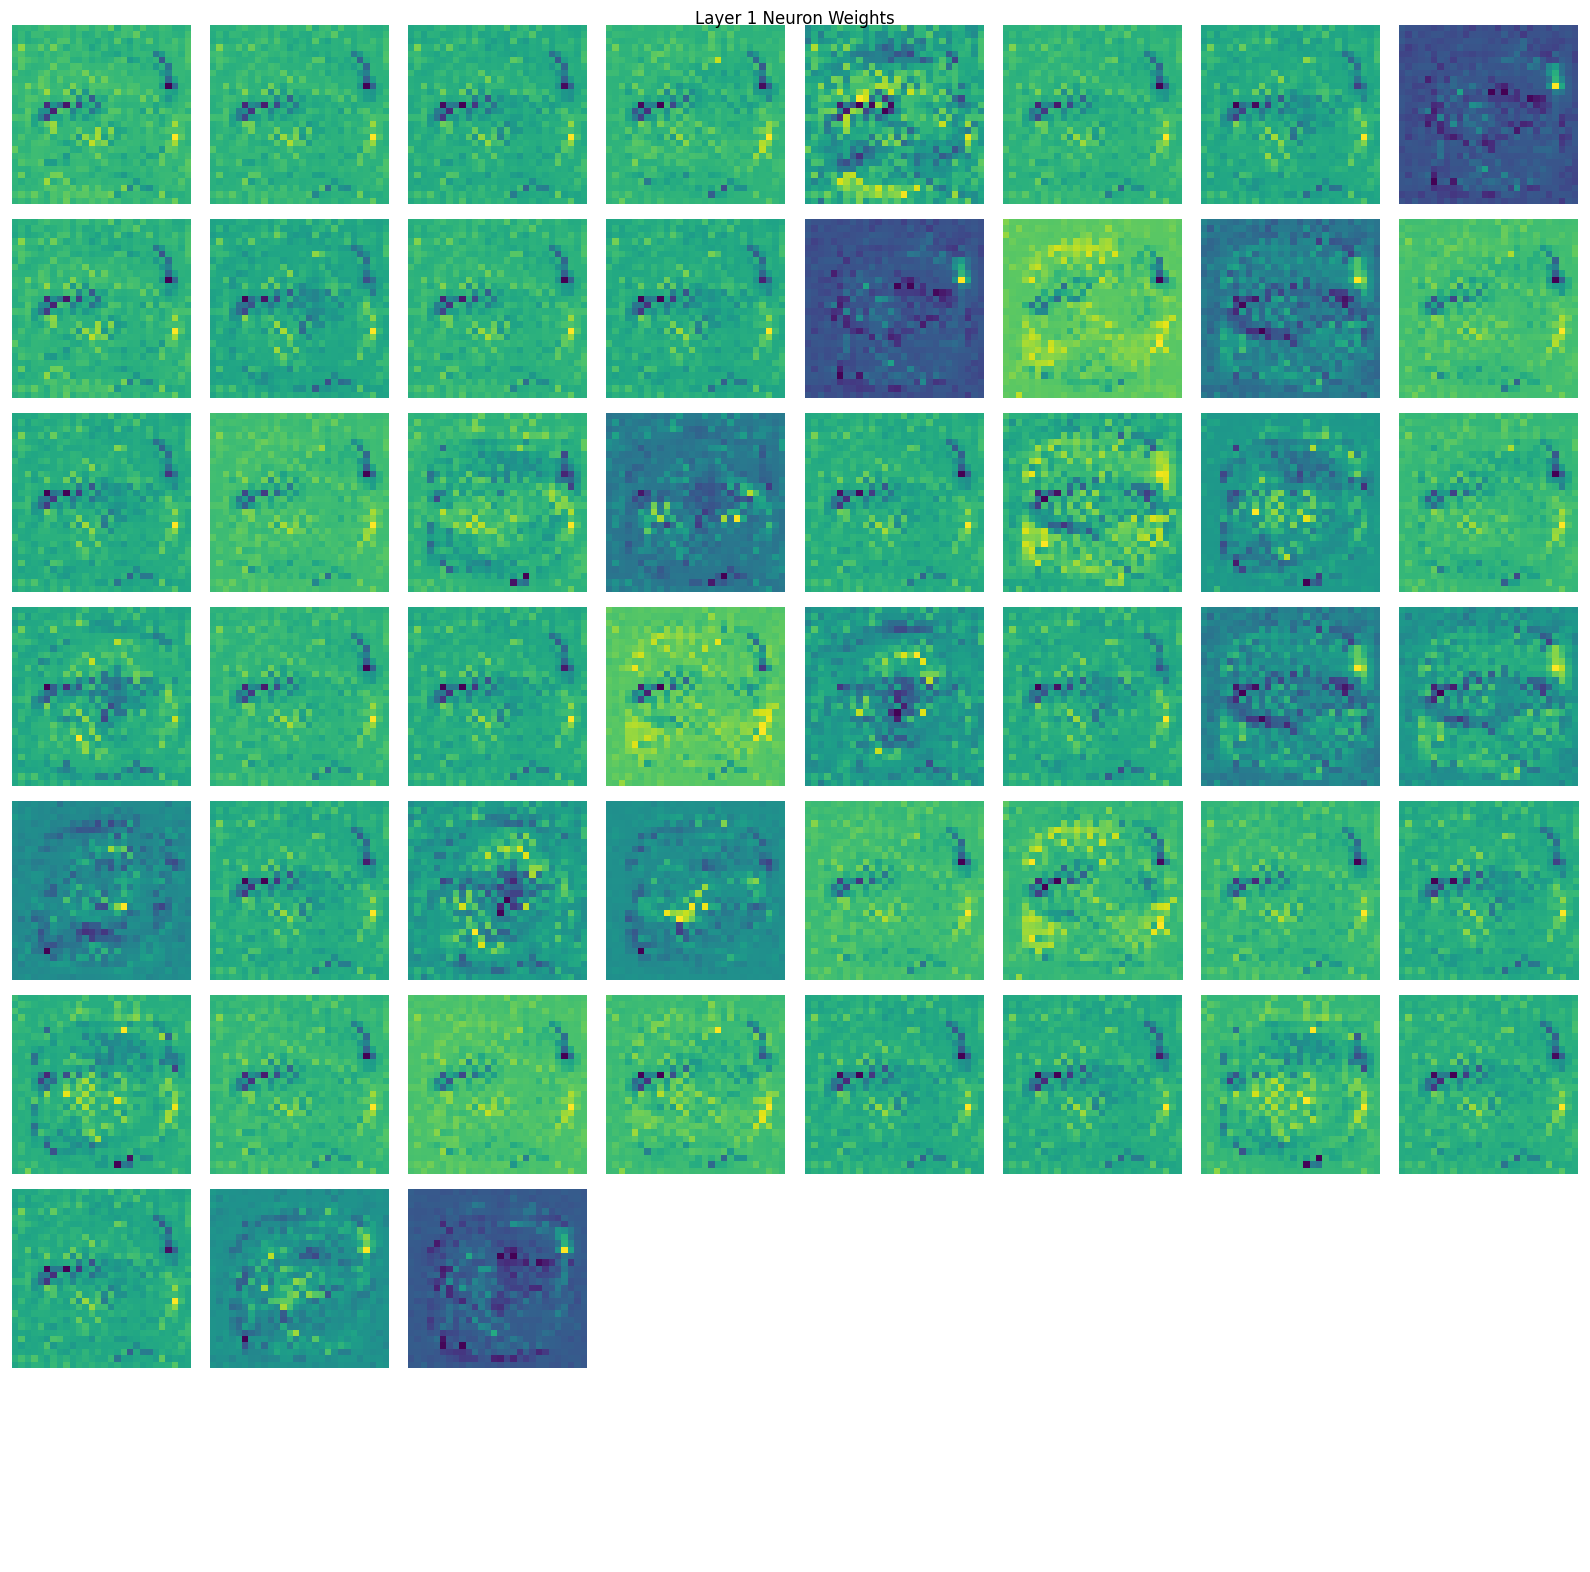

In [ ]:
visualize_first_layer_weights(model.layers)

In [ ]:
# print rank of first layer
print(f"Rank of first layer: {np.linalg.matrix_rank(model.layers[0].weight.detach().cpu().numpy())}")
print("Shape of first layer weights: ", model.layers[0].weight.shape)
print(f"Rank of second layer: {np.linalg.matrix_rank(model.layers[1].weight.detach().cpu().numpy())}")
print("Shape of second layer weights: ", model.layers[1].weight.shape)
print(f"Rank of third layer: {np.linalg.matrix_rank(model.layers[2].weight.detach().cpu().numpy())}")
print("Shape of third layer weights: ", model.layers[2].weight.shape)


# Rank 1 cicj
# Rank of first layer: 74
# Shape of first layer weights:  torch.Size([256, 784])
# Rank of second layer: 49
# Shape of second layer weights:  torch.Size([128, 256])
# Rank of third layer: 10
# Shape of third layer weights:  torch.Size([10, 128])

# Rank 10 cicj
# Rank of first layer: 220
# Shape of first layer weights:  torch.Size([256, 784])
# Rank of second layer: 124
# Shape of second layer weights:  torch.Size([128, 256])
# Rank of third layer: 10
# Shape of third layer weights:  torch.Size([10, 128])

Rank of first layer: 79
Shape of first layer weights:  torch.Size([256, 784])
Rank of second layer: 49
Shape of second layer weights:  torch.Size([128, 256])
Rank of third layer: 10
Shape of third layer weights:  torch.Size([10, 128])


In [ ]:
# laod the model
if not train:
    model = HebbianNetworkClassifier(model_size, device=device, init="uni", dropout=0.1, rank=rank, bias=False, activation=torch.functional.F.relu)
    model.load_state_dict(torch.load("hebbian_mnist.pt"))
    model.reset_weights('linear')

    test_loss, test_accuracy, confusion_matrix = model.test(test_loader, loss_fn)
    print(f"Test accuracy: {test_accuracy}")
    print(f"Test loss: {test_loss}")

# plot the confusion matrix

/Users/user/Desktop/Uni/SBM/utility/HebbianNetwork.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.layers[0].weight = torch.tensor(samples.clone().detach(), device=self.device, dtype=torch.float32)
Test: 100%|██████████| 20/20 [00:02<00:00,  6.86batch/s, Loss=0.446]                                         


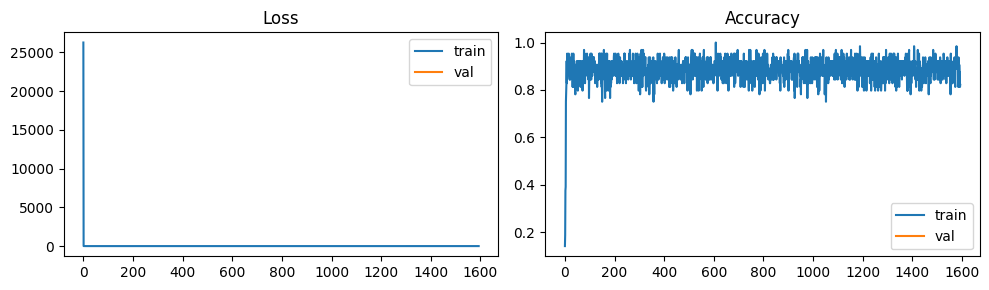

Test accuracy: 0.8921760110294118
Test loss: 8.193704244845054e-05


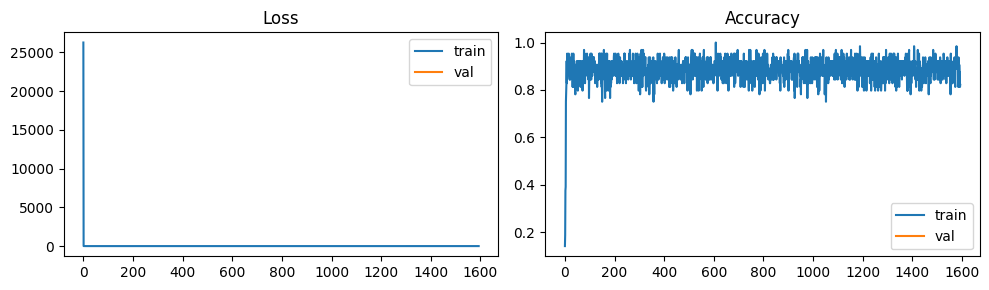

In [ ]:
train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy, confusion_matrix = model.hebbian_train_loop(
    loss_fn, train_loader, None, test_loader, max_iter=3000, epochs=2
)

# plot the results
plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy)

# print the test results
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy)

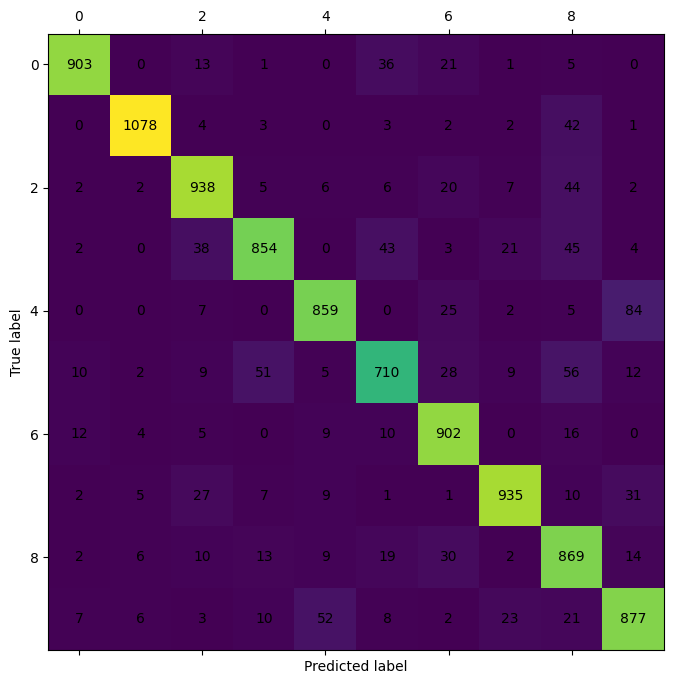

In [ ]:
print_confusion_matrix(confusion_matrix)

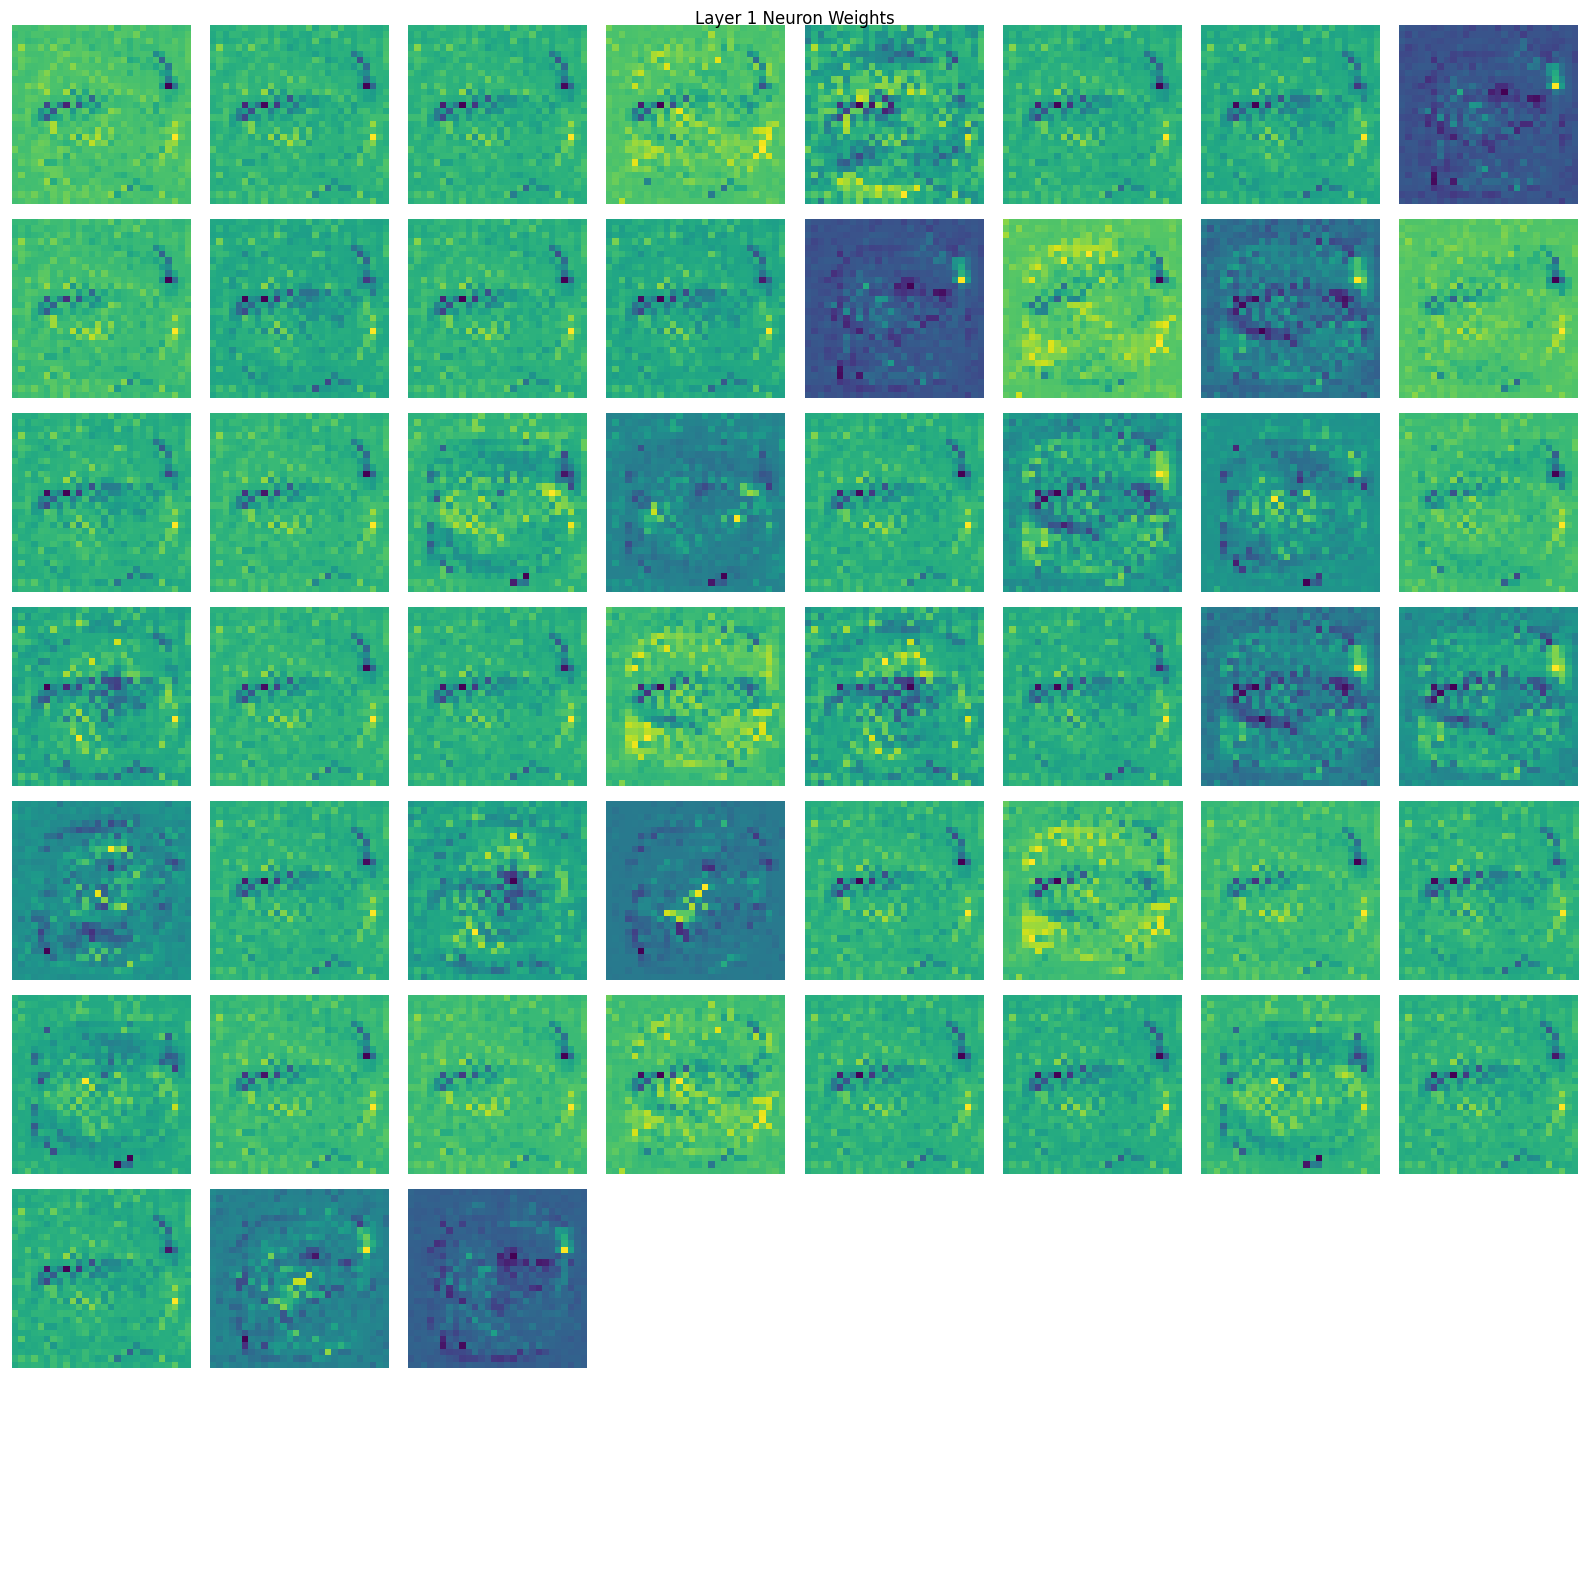

In [ ]:
visualize_first_layer_weights(model.layers)


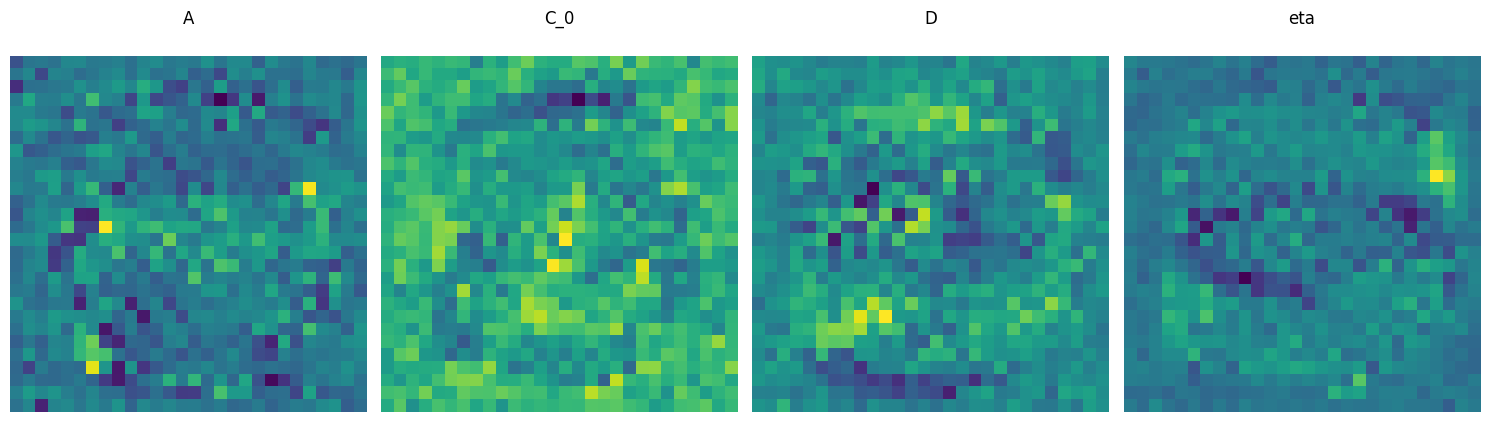

In [ ]:
printACDE(model)

In [ ]:
# normal backpropagation

import torch.nn as nn

backprop_model = nn.Sequential(
    nn.Linear(784, 256, bias=False),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128, bias=False),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 10, bias=False),
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()

backprop_optimizer = torch.optim.AdamW(backprop_model.parameters(), lr=0.001, weight_decay=0.0)

num_epochs = 5
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in train_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = backprop_model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        backprop_optimizer.step()
        backprop_optimizer.zero_grad()
        
        # Track training loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = backprop_model(images)
            loss = loss_fn(outputs, labels)
            
            # Track validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate average losses and accuracies
    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)
    val_loss /= len(val_dataset)
    val_accuracy = val_correct / len(val_dataset)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Final test
model.eval()
test_loss = 0.0
test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = backprop_model(images)
        loss = loss_fn(outputs, labels)
        
        # Track test loss and accuracy
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
test_loss /= len(test_dataset)
test_accuracy = test_correct / len(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/5], Train Loss: 0.2594, Train Accuracy: 0.9220, Val Loss: 0.1427, Val Accuracy: 0.9553
Epoch [2/5], Train Loss: 0.1160, Train Accuracy: 0.9640, Val Loss: 0.1198, Val Accuracy: 0.9629
Epoch [3/5], Train Loss: 0.0862, Train Accuracy: 0.9733, Val Loss: 0.1125, Val Accuracy: 0.9651
Epoch [4/5], Train Loss: 0.0692, Train Accuracy: 0.9784, Val Loss: 0.0995, Val Accuracy: 0.9701
Epoch [5/5], Train Loss: 0.0573, Train Accuracy: 0.9815, Val Loss: 0.1047, Val Accuracy: 0.9698
Test Loss: 0.0875, Test Accuracy: 0.9746


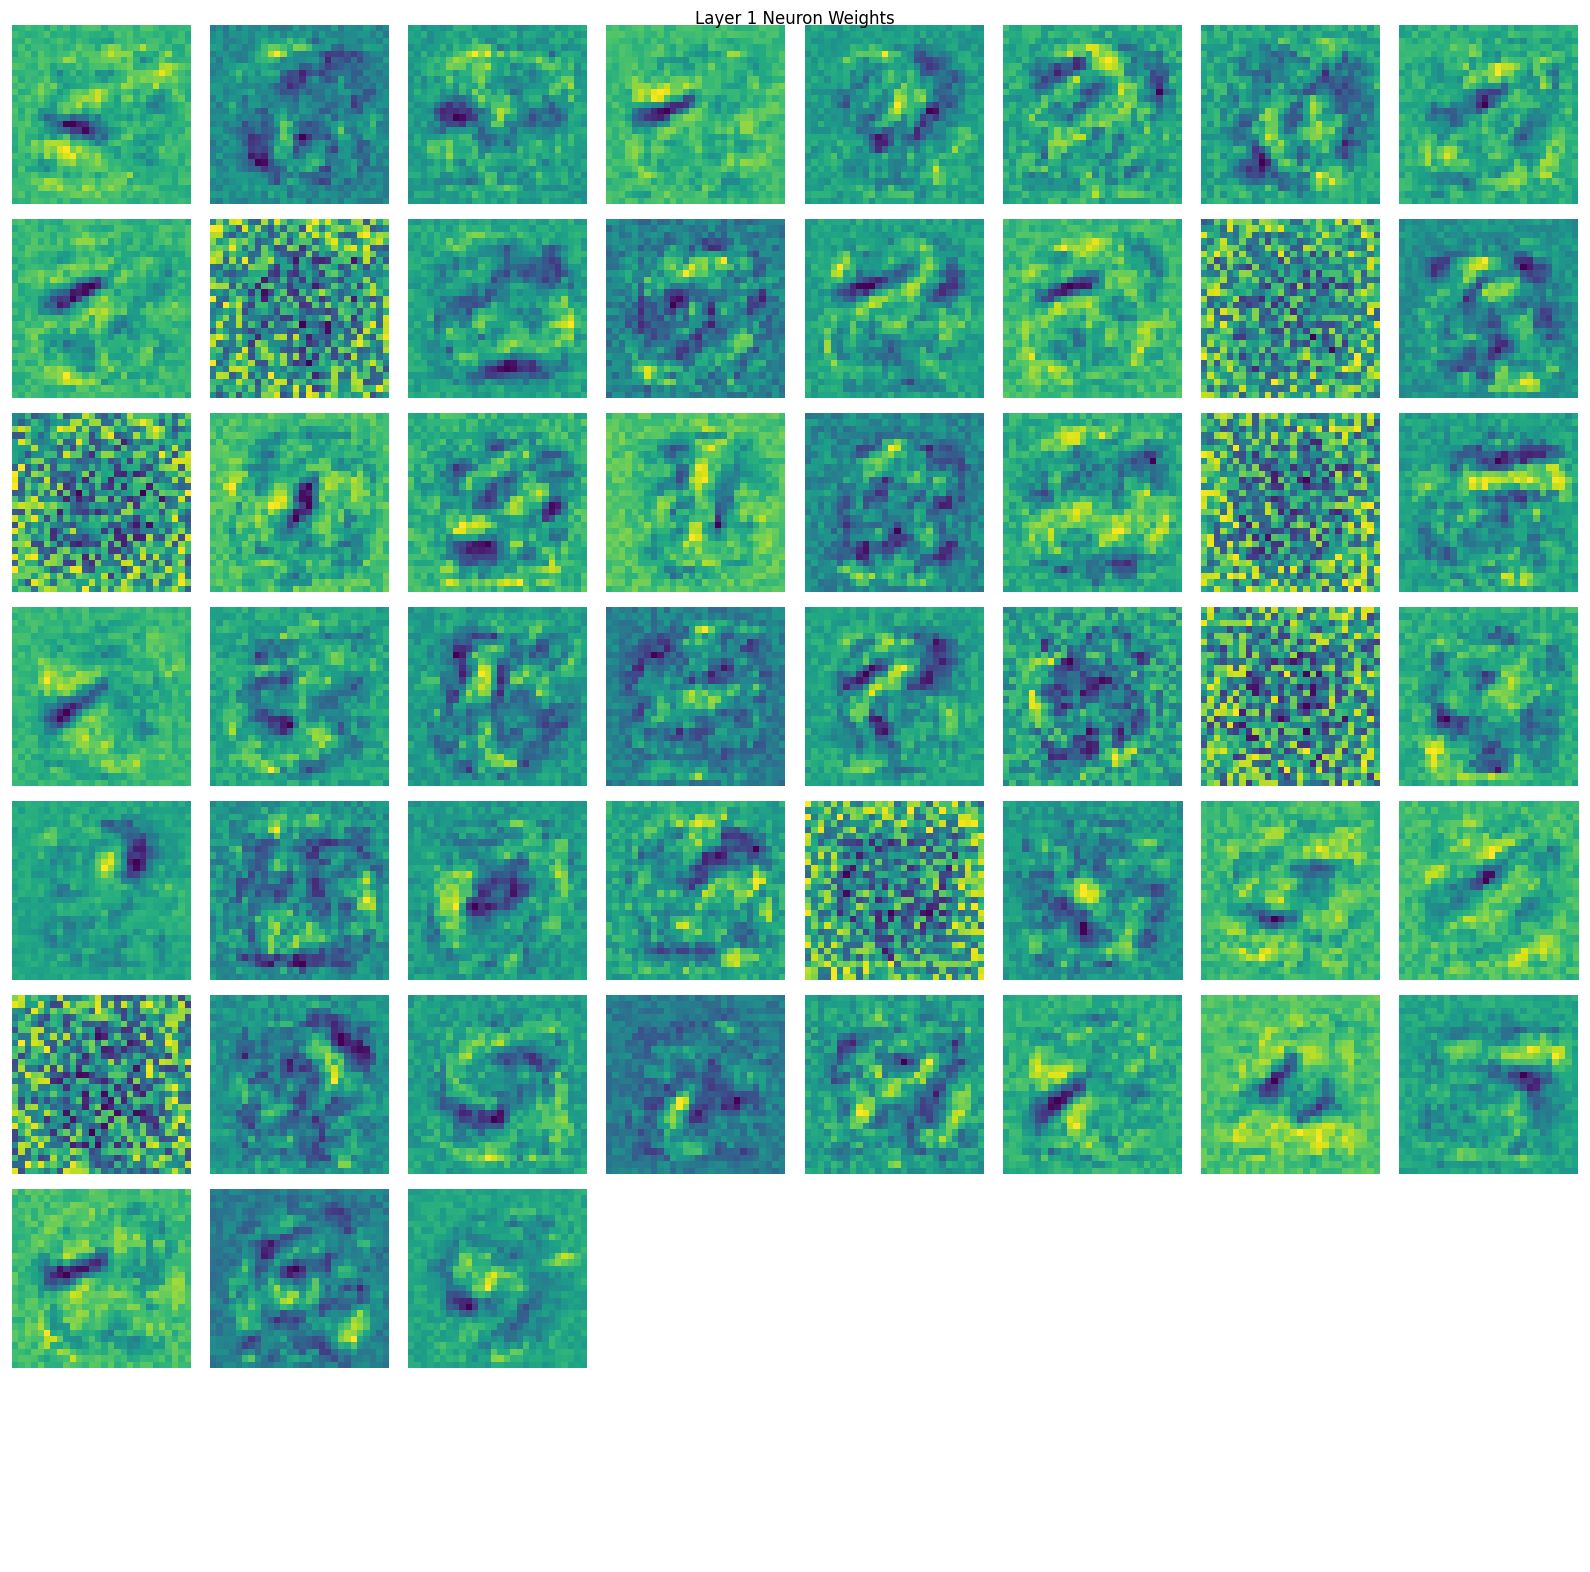

In [ ]:
visualize_first_layer_weights(backprop_model)

In [ ]:
print(f"Rank of first layer: {np.linalg.matrix_rank(backprop_model[0].weight.detach().cpu().numpy())}")
print("Shape of first layer weights: ", backprop_model[0].weight.shape)
print(f"Rank of second layer: {np.linalg.matrix_rank(backprop_model[3].weight.detach().cpu().numpy())}")
print("Shape of second layer weights: ", backprop_model[3].weight.shape)
print(f"Rank of third layer: {np.linalg.matrix_rank(backprop_model[6].weight.detach().cpu().numpy())}")
print("Shape of third layer weights: ", backprop_model[6].weight.shape)

Rank of first layer: 256
Shape of first layer weights:  torch.Size([256, 784])
Rank of second layer: 128
Shape of second layer weights:  torch.Size([128, 256])
Rank of third layer: 10
Shape of third layer weights:  torch.Size([10, 128])
